# Plots
This notebook contains the code used to create the plots for the final thesis

In [41]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import parselmouth

In [42]:
# Set global plot style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 3})
colors = sns.color_palette()

## SVM w/ LOO over class thresholds

In [43]:
# NOTE These were collected using the code in `src/notebooks/supplementary_experiments.ipynb`
columns = ["Threshold", "Classes", "Accuracy", "Set", "Undersampling"]
perf_data = [
    (1, 53, 1.0, "Train", "Without  "),(1, 53, 0.1117, "Test", "Without  "),
    (2, 34, 1.0, "Train", "Without  "),(2, 34, 0.1243, "Test", "Without  "),
    (3, 23, 1.0, "Train", "Without  "),(3, 23, 0.1429, "Test", "Without  "),
    (4, 19, 1.0, "Train", "Without  "),(4, 19, 0.1556, "Test", "Without  "),
    (5, 15, 1.0, "Train", "Without  "),(5, 15, 0.1765, "Test", "Without  "),
    (6, 12, 1.0, "Train", "Without  "),(6, 12, 0.2019, "Test", "Without  "),
    (7, 10, 1.0, "Train", "Without  "),(7, 10, 0.2283, "Test", "Without  "),
    (8,  6, 1.0, "Train", "Without  "),(8,  6, 0.3281, "Test", "Without  "),
    (9,  3, 1.0, "Train", "Without  "),(9,  3, 0.575, "Test", "Without  "),
    (10, 2, 1.0, "Train", "Without  "),(10, 2, 0.7419, "Test", "Without  "),
    (1, 53, 1.0, "Train", "With  "),(1, 53, 0.0, "Test", "With  "),
    (2, 34, 1.0, "Train", "With  "),(2, 34, 0.0, "Test", "With  "),
    (3, 23, 1.0, "Train", "With  "),(3, 23, 0.0, "Test", "With  "),
    (4, 19, 1.0, "Train", "With  "),(4, 19, 0.0395, "Test", "With  "),
    (5, 15, 1.0, "Train", "With  "),(5, 15, 0.08, "Test", "With  "),
    (6, 12, 1.0, "Train", "With  "),(6, 12, 0.0417, "Test", "With  "),
    (7, 10, 1.0, "Train", "With  "),(7, 10, 0.0571, "Test", "With  "),
    (8,  6, 1.0, "Train", "With  "),(8,  6, 0.2917, "Test", "With  "),
    (9,  3, 1.0, "Train", "With  "),(9,  3, 0.4444, "Test", "With  "),
    (13, 2, 1.0, "Train", "With  "),(13, 2, 0.6538, "Test", "With  "),
]
df = pd.DataFrame(columns=columns, data=perf_data)

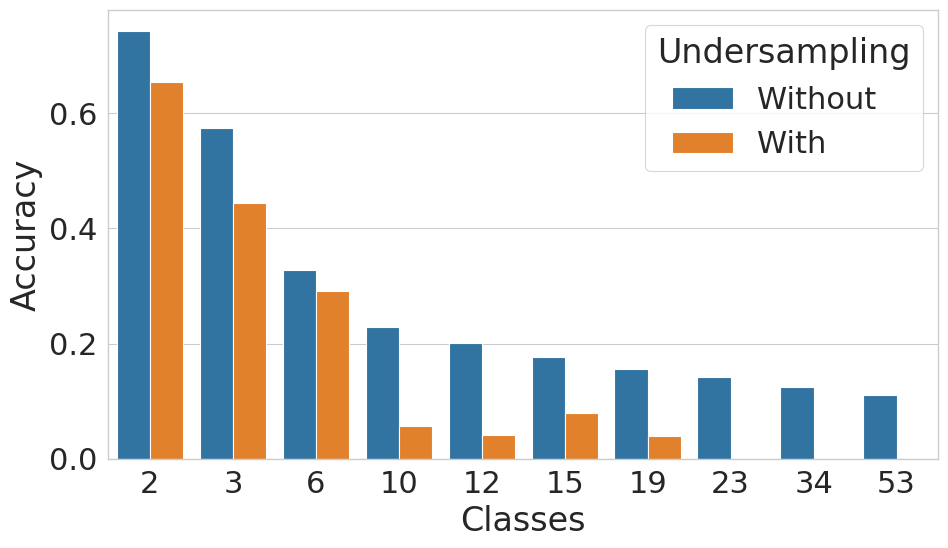

In [44]:
plt.figure(figsize=(10,6))
sns.barplot(data=df[df.Set == "Test"], x="Classes", y="Accuracy", hue="Undersampling")
plt.tight_layout()
plt.savefig("../../plots/SVM-LOO-TestAcc")
plt.show()

## Distribution of brain data words

In [45]:
with open('../../data/HP1_ECoG_conditional/sub-002/about_word-counts.txt', 'r') as f:
    word_counts = f.read().split(',')
word_counts = [wc.split(':') for wc in word_counts]
df = pd.DataFrame(data=word_counts, columns=['Word', 'Count'])
df.Count = df.Count.astype('int')

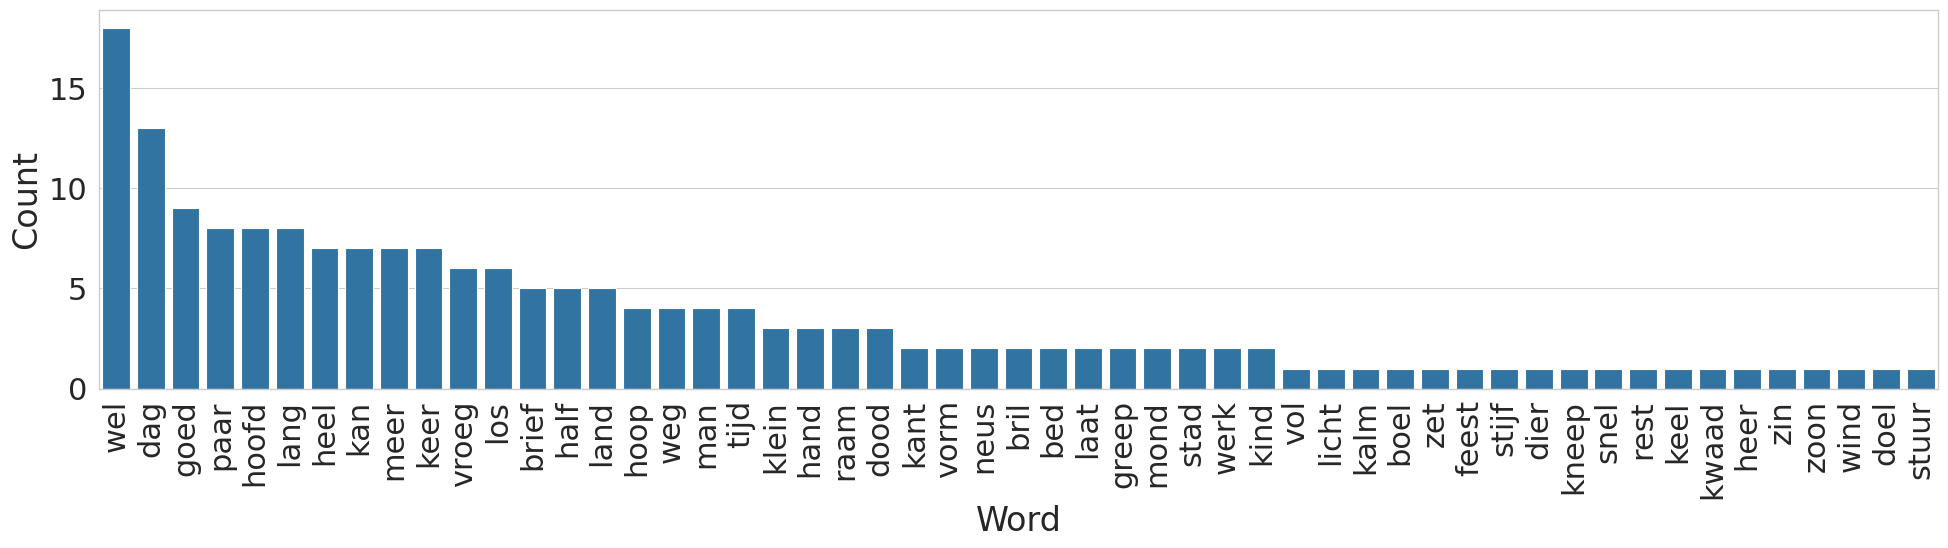

In [46]:
plt.figure(figsize=(20,6))
sns.barplot(data=df, x='Word', y='Count', color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../../plots/Brain-Words-Distribution")
plt.show()

## Brain Classifier

In [47]:
ckpt_path = "../../exp/Brain-Classifier/sub-002"
with open(os.path.join(ckpt_path, 'logs.json'), "r") as f:
    logs = json.load(f)

In [48]:
os.makedirs("../../plots/brain_classifier", exist_ok=True)

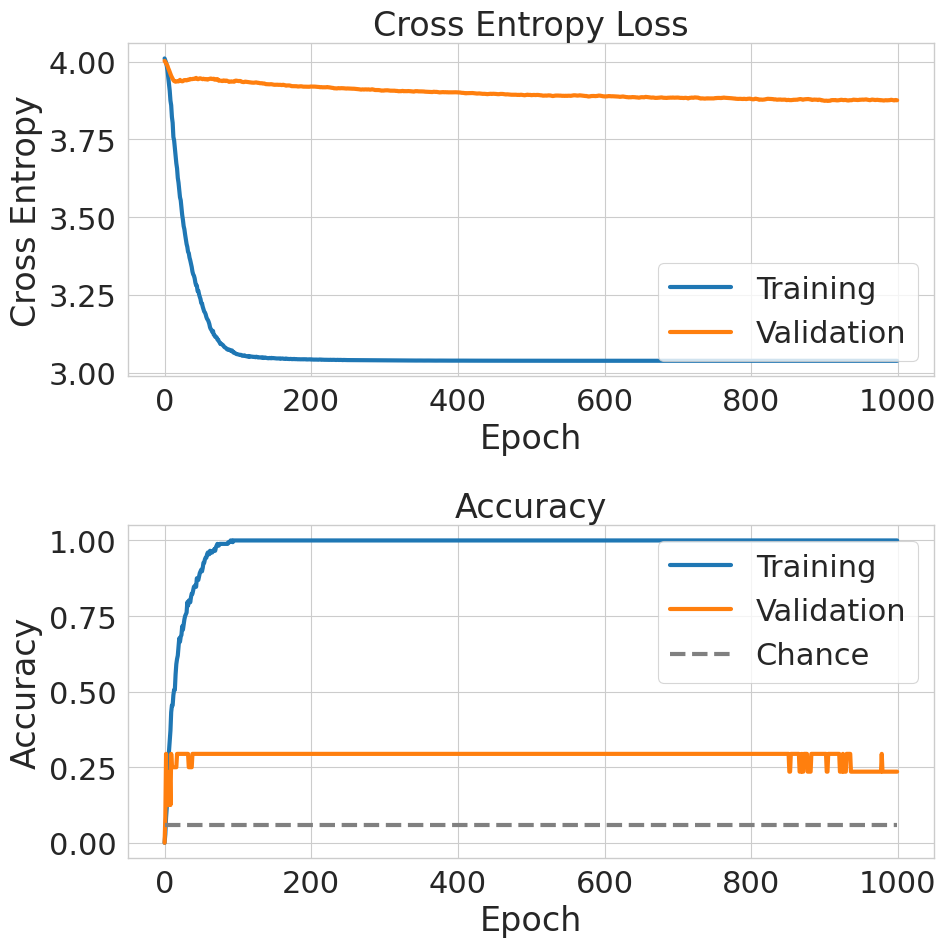

In [49]:
colors = sns.color_palette()

start_idx = 0
end_idx = 1000

plt.figure(figsize=(10,10))

plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(logs['train_loss_epoch'][start_idx:end_idx], color=colors[0], label='Training')
plt.plot(logs['val_loss_epoch'][start_idx:end_idx], color=colors[1], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend(loc=4)

plt.subplot(212)
plt.title('Accuracy')
plt.plot(logs['train_acc_epoch'][start_idx:end_idx], color=colors[0], label='Training')
plt.plot(logs['val_acc_epoch'][start_idx:end_idx], color=colors[1], label='Validation')
plt.plot([0.0588]*1000, color='grey', linestyle='--', label='Chance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig("../../plots/brain_classifier/Brain-Classifier-Loss")
plt.show()

In [50]:
with open(os.path.join(ckpt_path, 'predictions_e800.json'), 'r') as f:
    preds = json.load(f)

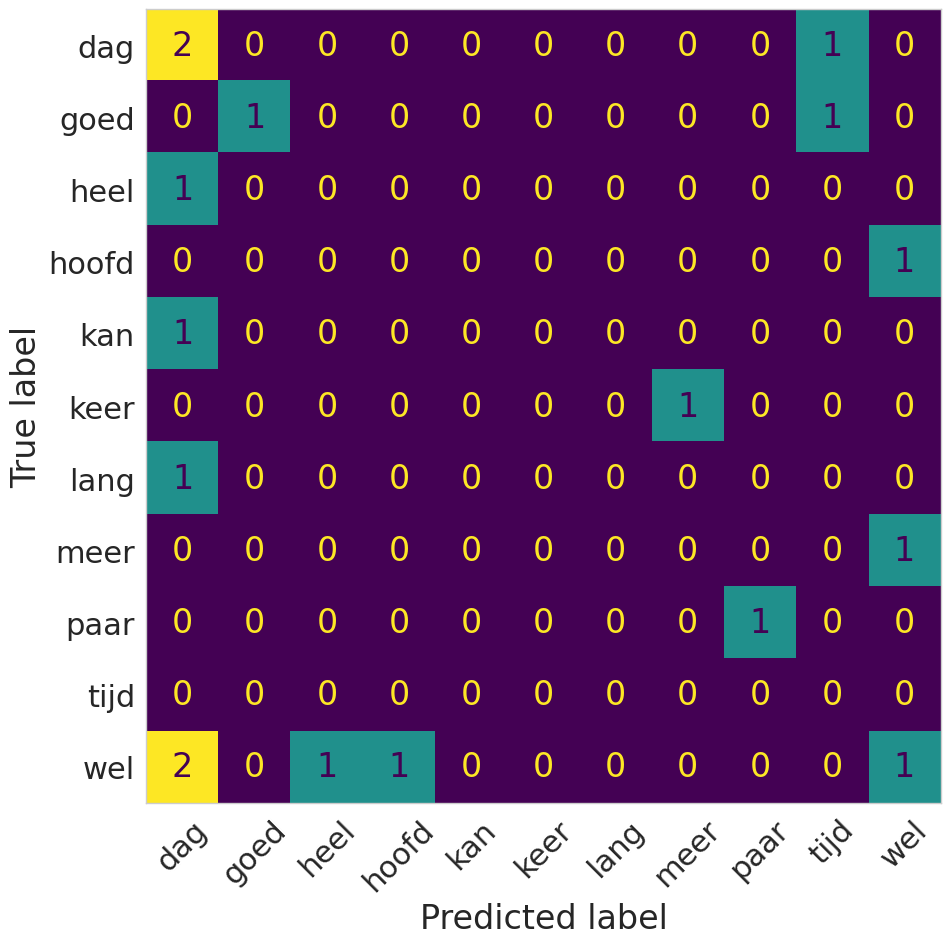

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1,1,figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(
    preds['val_true'], preds['val_preds'], ax=ax, colorbar=False, xticks_rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig("../../plots/brain_classifier/Brain-Classifier-ConfMatVal-Epoch800")
plt.show()

## Spectrograms

In [52]:
def draw_spectrogram(host, spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values + 1e-16)
    host.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='viridis')
    host.set_ylim([spectrogram.ymin, spectrogram.ymax])

def draw_intensity(host, intensity):
    host.plot(intensity.xs(), intensity.values.T, linewidth=2, color='w')
    host.plot(intensity.xs(), intensity.values.T, linewidth=1)
    host.grid(False)
    host.set_ylim(0)
    host.set_yticks([])

def draw_pitch(host, pitch):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    host.plot(pitch.xs(), pitch_values, 'o', markersize=2, color='w')
    host.plot(pitch.xs(), pitch_values, 'o', markersize=1, color='r')
    host.grid(False)
    host.set_ylim(0, pitch.ceiling)
    host.set_yticks([])

def plot_one(host, spectrogram, intensity, pitch):
    par1 = host.twinx()
    par2 = host.twinx()
    draw_spectrogram(host, spectrogram)
    draw_intensity(par1, intensity)
    draw_pitch(par2, pitch)
    host.set_xlim([0.01, 0.23])
    par1.set_xlim([0.01, 0.23])
    par2.set_xlim([0.01, 0.23])
    host.set_yticks([])
    host.set_xticks([])

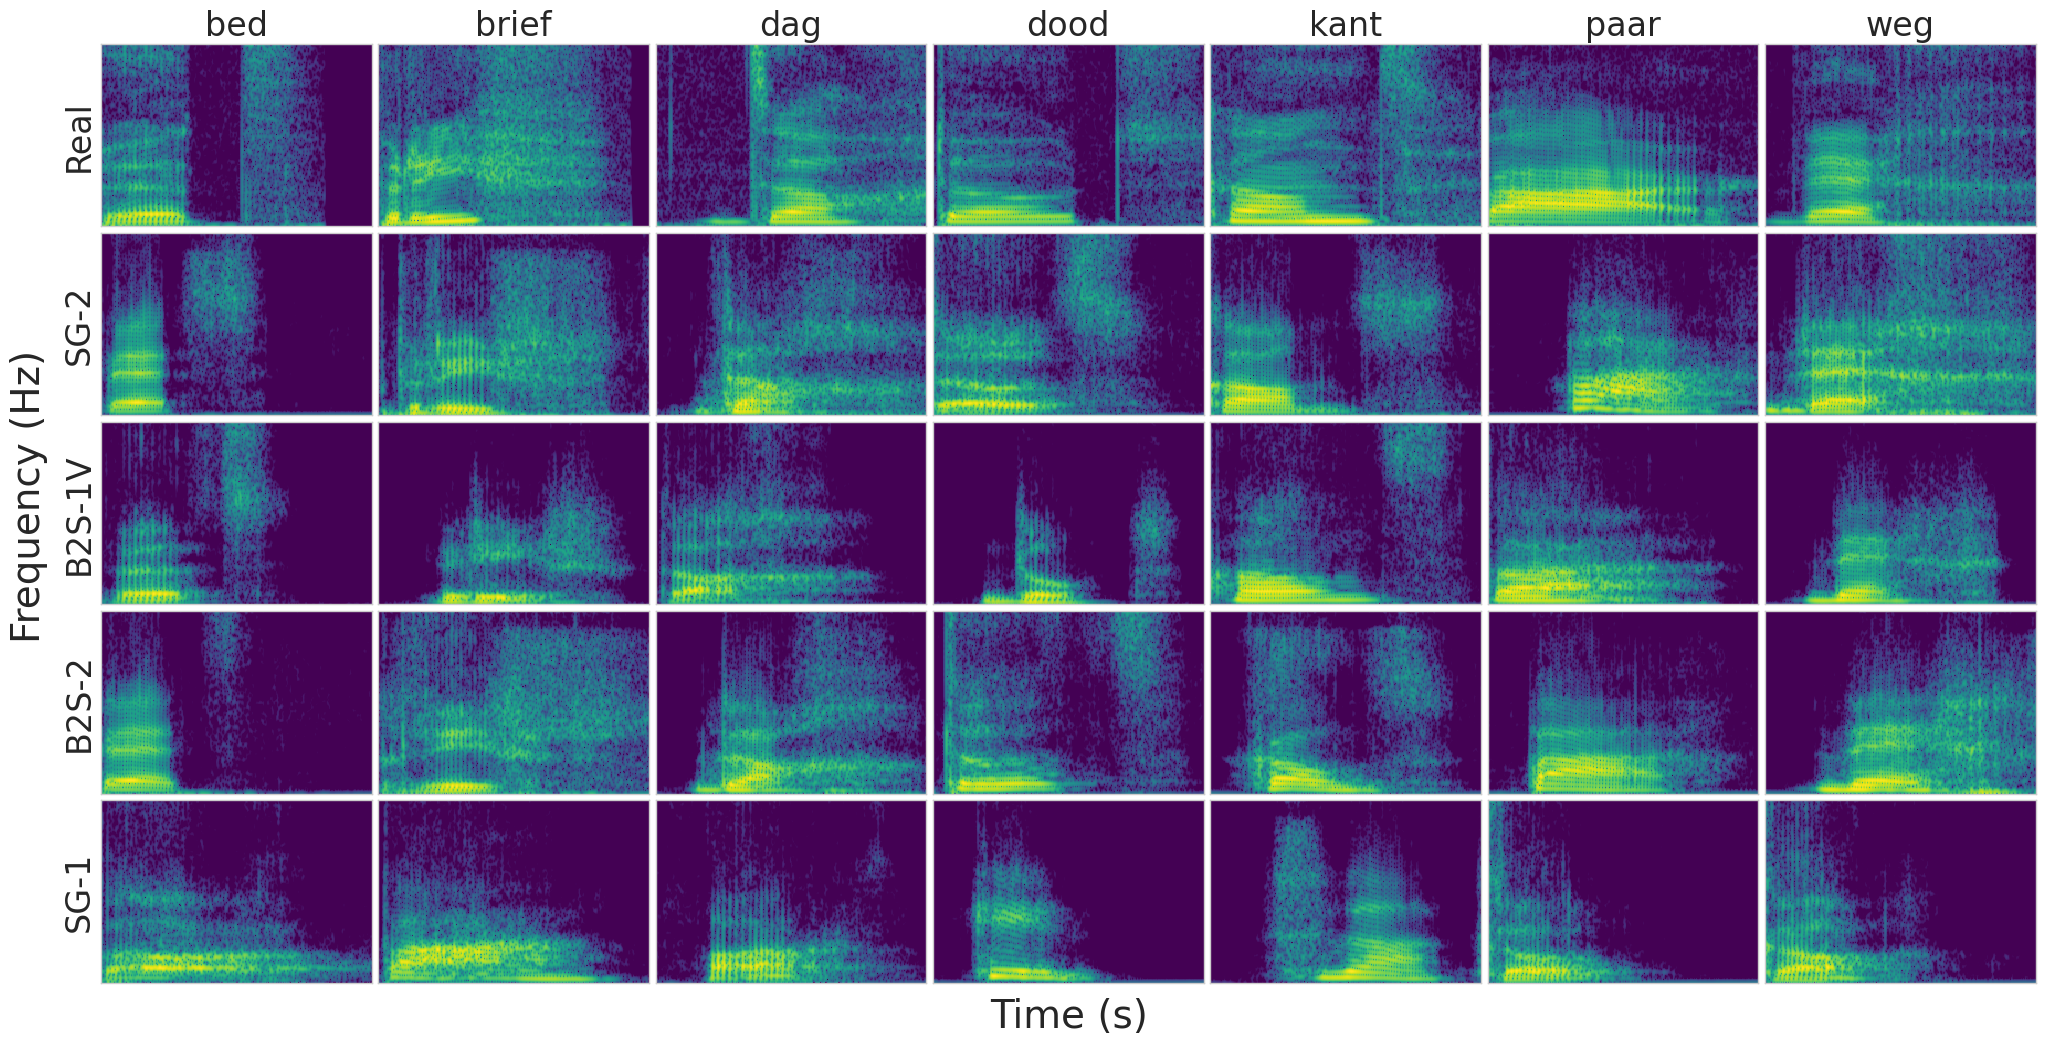

In [53]:
words = ["bed", "brief", "dag", "dood", "kant", "paar", "weg"]

d = {
    'Real': {
        'path': "../../data/VariaNTS/VariaNTS_words_16kHz_HP_flattened_fixed-length",
        'files': ["p03_bed", "p04_brief", "p08_dag", "p02_dood", "p11_kant", "p12_paar", "p15_weg"],
    },
    'SG-2': {
        'path': "../../exp/SG-C_v3/waveforms/180/all",
        'files': ["bed_3", "brief_0", "dag_6", "dood_0", "kant_1", "paar_1", "weg_11"],
    },
    'B2S-1V': {
        'path': "../../exp/B2S-UV_v3/waveforms/140/train",
        'files': ["bed1_1", "brief1_0", "dag6_0", "dood3_3", "kant2_5", "paar3_0", "weg2_3"],
    },
    'B2S-2': {
        'path': "../../exp/B2S-CV_v9/waveforms/800/train",
        'files': ["bed1_2", "brief4_0", "dag6_0", "dood1_1", "kant2_4", "paar2_0", "weg3_0"],
    },
    'SG-1': {
        'path': "../../exp/SG-U_v9/waveforms/230/all",
        'files': ["2", "3", "7", "8", "10", "13", "16"],
    },
}

fig = plt.figure(figsize=(20,10))
axs = fig.subplots(nrows=len(d), ncols=len(words), sharex=True, sharey=True)

i=0
for row, (run_name, run_args) in zip(*[axs, d.items()]):
    for j, col in enumerate(row):
        full_file_path = os.path.join(run_args['path'], run_args['files'][j]) + '.wav'

        s1 = parselmouth.Sound(full_file_path)
        spectrogram = s1.to_spectrogram(window_length=0.01, maximum_frequency=8000)
        draw_spectrogram(col, spectrogram)

        col.set_xticks([])
        col.set_yticks([])
        col.set_xlim([0.01, 0.5])
        if j==0:
            col.set_ylabel(run_name)
        if i==0:
            col.set_title(words[j])
    i+=1

fig.text(0.51, -0.02, 'Time (s)', ha='center', va='center', fontsize=28)
fig.text(-0.01, 0.5, 'Frequency (Hz)', ha='center', va='center', rotation='vertical', fontsize=28)

plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.2)

# NOTE Somehow the axis texts are not exported when using savefig.
# FIX: Save from the output of this cell
# plt.savefig("../../plots/Real-vs-Generated-Spectrograms")
plt.show()

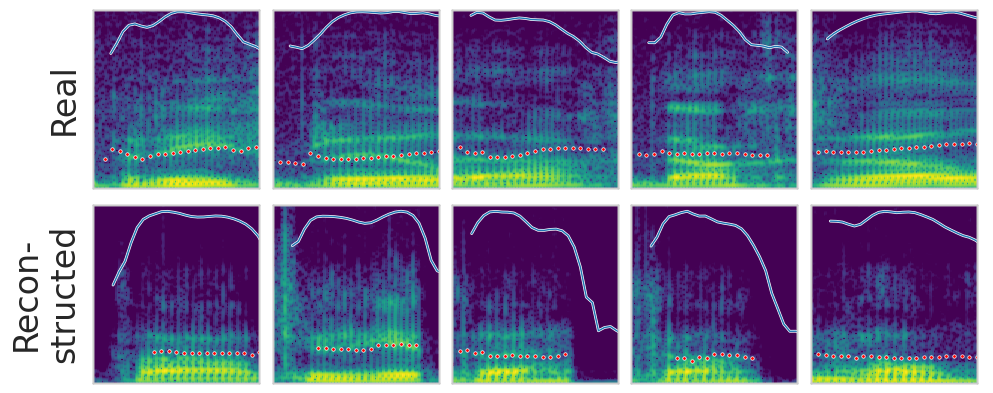

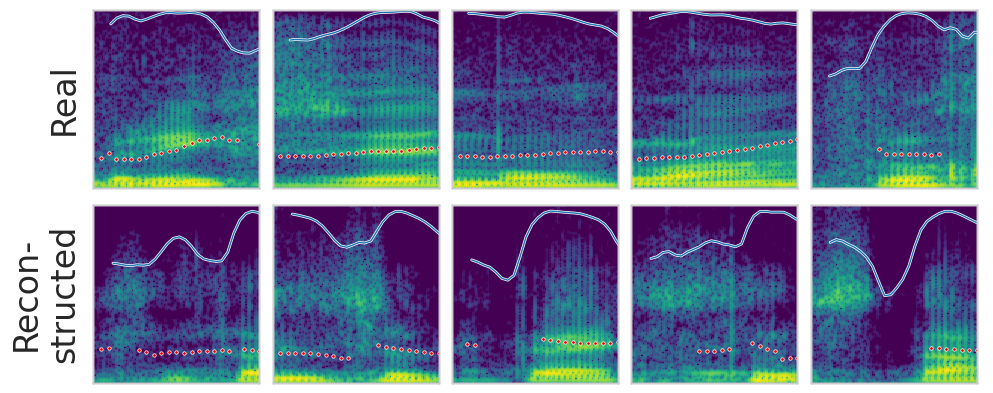

In [54]:
d = {
    'Real': {
        'path': "../../data/HP1_ECoG_conditional/sub-002",
        'good_files': ["brief4", "bril2", "dag7", "dag11", "wel18"],
        'bad_files': ["brief3", "zin1", "mond1", "lang7", "vroeg1"]
    },
    'Recon-\nstructed': {
        'path': "../../exp/B2S-UR_v5/waveforms/70/train",
        'good_files': ["brief4_2", "bril2_1", "dag7_0", "dag11_0", "wel18_0"],
        'bad_files': ["brief3_1", "zin1_4", "mond1_3", "lang7_0", "vroeg1_2"]
    },
}

fig = plt.figure(figsize=(10,4))
axs = fig.subplots(nrows=len(d), ncols=5, sharex=True, sharey=True)

for row, (run_name, run_args) in zip(*[axs, d.items()]):
    run_args['path']
    for j, col in enumerate(row):
        full_file_path = os.path.join(run_args['path'], run_args['good_files'][j]) + '.wav'
        s1 = parselmouth.Sound(full_file_path)
        if j==0:
            col.set_ylabel(run_name)
        intensity = s1.to_intensity(minimum_pitch=100)
        spectrogram = s1.to_spectrogram(window_length=0.01, maximum_frequency=8000)
        pitch = s1.to_pitch()
        plot_one(col, spectrogram, intensity, pitch)

plt.tight_layout(pad=0.4, w_pad=0., h_pad=0.5)
plt.savefig('../../plots/Real-vs-Reconstructed-Spectrograms-HP-Good')
plt.show()

fig = plt.figure(figsize=(10,4))
axs = fig.subplots(nrows=len(d), ncols=5, sharex=True, sharey=True)

for row, (run_name, run_args) in zip(*[axs, d.items()]):
    run_args['path']
    for j, col in enumerate(row):
        full_file_path = os.path.join(run_args['path'], run_args['bad_files'][j]) + '.wav'
        s1 = parselmouth.Sound(full_file_path)
        if j==0:
            col.set_ylabel(run_name)
        intensity = s1.to_intensity(minimum_pitch=100)
        spectrogram = s1.to_spectrogram(window_length=0.01, maximum_frequency=8000)
        pitch = s1.to_pitch()
        plot_one(col, spectrogram, intensity, pitch)

plt.tight_layout(pad=0.4, w_pad=0., h_pad=0.5)
plt.savefig('../../plots/Real-vs-Reconstructed-Spectrograms-HP-Bad')
plt.show()

## Effect of Data Augmentation

In [55]:
loss_df = pd.read_csv('../../exp/loss_data_aug_effect.csv')
loss_df['Time (hours)'] = loss_df['Relative Time (Process)'] / (60*60)

In [56]:
smoothing = 0.1
for model in ['Uncond-PT-v9-noaug', 'Uncond-PT-v9']:
    loss_df[f'{model} - train/log_loss_epoch - rolling'] = loss_df[f'{model} - train/log_loss_epoch'].dropna().ewm(alpha=smoothing).mean()
    loss_df[f'{model} - val/log_loss - rolling'] = loss_df[f'{model} - val/log_loss'].dropna().ewm(alpha=smoothing).mean()

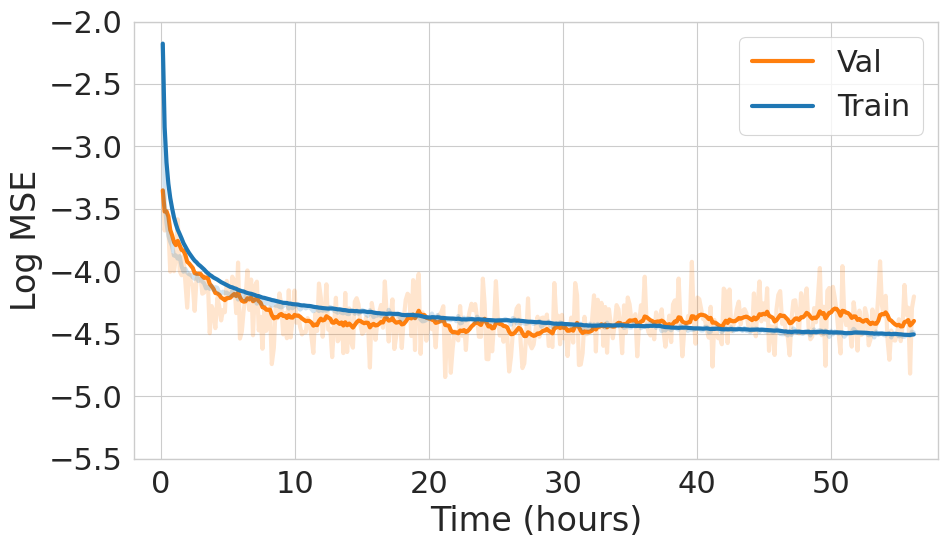

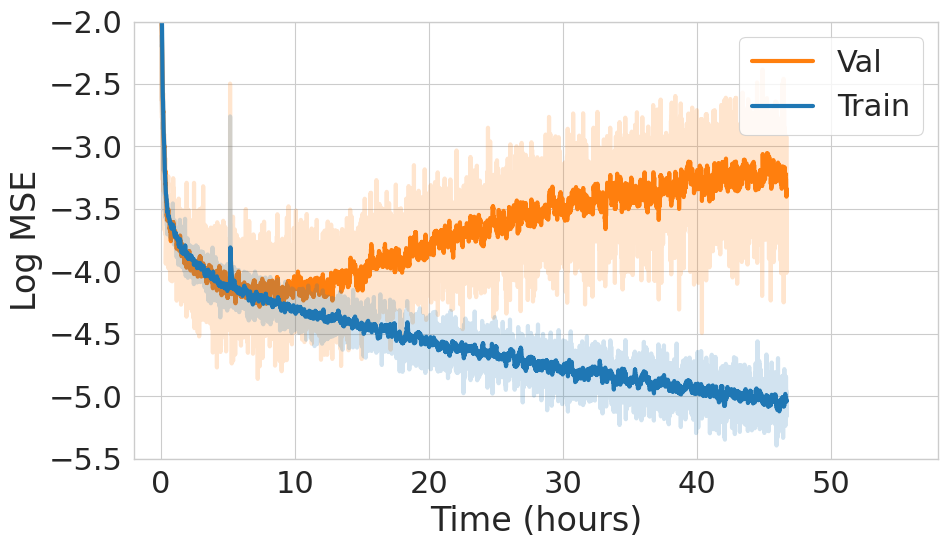

In [57]:
# Opacity of non-smoothed loss curves
alpha = 0.2

# With Augmentations
plt.figure(figsize=(10,6))
sns.lineplot(data=loss_df, x='Time (hours)', y='Uncond-PT-v9 - val/log_loss', color=colors[1], alpha=alpha)
sns.lineplot(data=loss_df, x='Time (hours)', y='Uncond-PT-v9 - val/log_loss - rolling', color=colors[1], label='Val')
sns.lineplot(data=loss_df, x='Time (hours)', y='Uncond-PT-v9 - train/log_loss_epoch', color=colors[0], alpha=alpha)
sns.lineplot(data=loss_df, x='Time (hours)', y='Uncond-PT-v9 - train/log_loss_epoch - rolling', color=colors[0], label='Train')
plt.ylabel('Log MSE')
plt.xlim(-2, 58)
plt.ylim(-5.5, -2)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig("../../plots/Loss-Effects-Augmentation-Aug")

# Without Augmentations
plt.figure(figsize=(10,6))
sns.lineplot(data=loss_df, x='Time (hours)', y='Uncond-PT-v9-noaug - val/log_loss', color=colors[1], alpha=alpha)
sns.lineplot(data=loss_df, x='Time (hours)', y='Uncond-PT-v9-noaug - val/log_loss - rolling', color=colors[1], label='Val')
sns.lineplot(data=loss_df, x='Time (hours)', y='Uncond-PT-v9-noaug - train/log_loss_epoch', color=colors[0], alpha=alpha)
sns.lineplot(data=loss_df, x='Time (hours)', y='Uncond-PT-v9-noaug - train/log_loss_epoch - rolling', color=colors[0], label='Train')
plt.ylabel('Log MSE')
plt.xlim(-2, 58)
plt.ylim(-5.5, -2)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig("../../plots/Loss-Effects-Augmentation-NoAug")

plt.show()

## Loss plots for all models

In [58]:
loss_df = pd.read_csv('../../exp/loss_all_models.csv')

In [59]:
models = ['Uncond-PT-v9', 'ClassCond-PT-v3', 'BrainCond-FT-VariaNTS-v3', 'BrainCond-FT-HP-v5']
chosen_epochs = [230, 180, 140, 70]
ylims = [(-5,-3.5),(-5,-3.5),(-4.8,-4.2),(-5.75,-4.25)]
ylims = [(-5,-2),(-5,-2),(-5.5,-3.5),(-6,-3.8)]

smoothing = 0.1

for model in models:
    loss_df[f'{model} - train/log_loss_epoch - rolling'] = loss_df[f'{model} - train/log_loss_epoch'].dropna().ewm(alpha=smoothing).mean()
    loss_df[f'{model} - val/log_loss - rolling'] = loss_df[f'{model} - val/log_loss'].dropna().ewm(alpha=smoothing).mean()

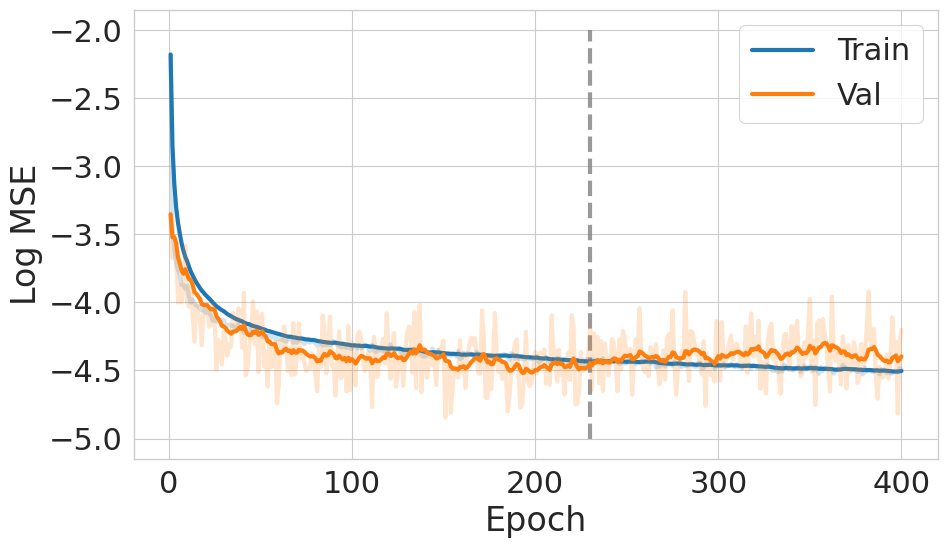

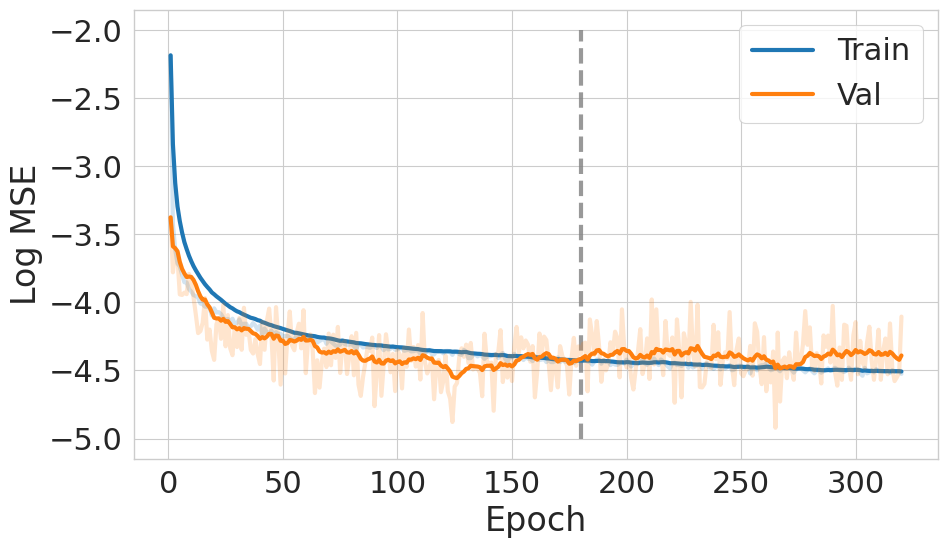

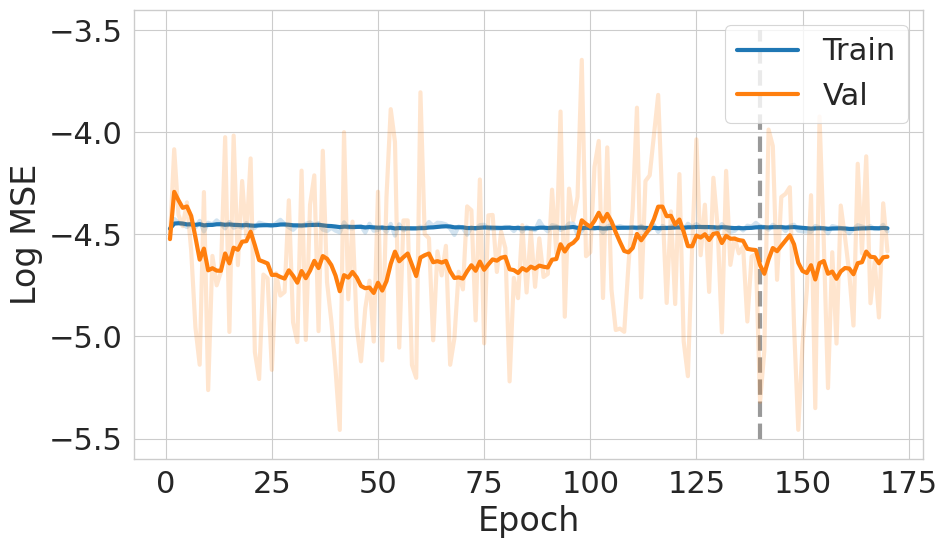

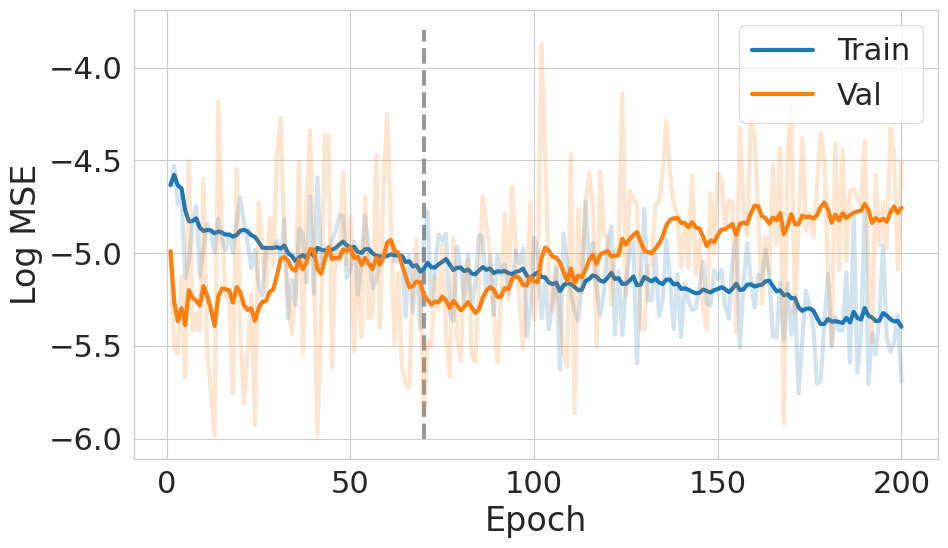

In [60]:
alpha = 0.2

for model, chosen_epoch,ylim in zip(*[models, chosen_epochs,ylims]):
    plt.figure(figsize=(10,6))

    plt.vlines(x=chosen_epoch, ymin=ylim[0], ymax=ylim[1], colors='grey', alpha=0.8, linestyles='dashed')
    sns.lineplot(data=loss_df, x='epoch', y=f'{model} - train/log_loss_epoch', color=colors[0], alpha=alpha)
    sns.lineplot(data=loss_df, x='epoch', y=f'{model} - train/log_loss_epoch - rolling', color=colors[0], label='Train')
    sns.lineplot(data=loss_df, x='epoch', y=f'{model} - val/log_loss', color=colors[1], alpha=alpha)
    sns.lineplot(data=loss_df, x='epoch', y=f'{model} - val/log_loss - rolling', color=colors[1], label='Val')
    plt.ylabel('Log MSE')
    plt.xlabel('Epoch')
    plt.legend(loc=1)
    plt.tight_layout()
    plt.savefig(f"../../plots/loss_plots/Loss-Prog_{model}")
    plt.show()

## Forward Process

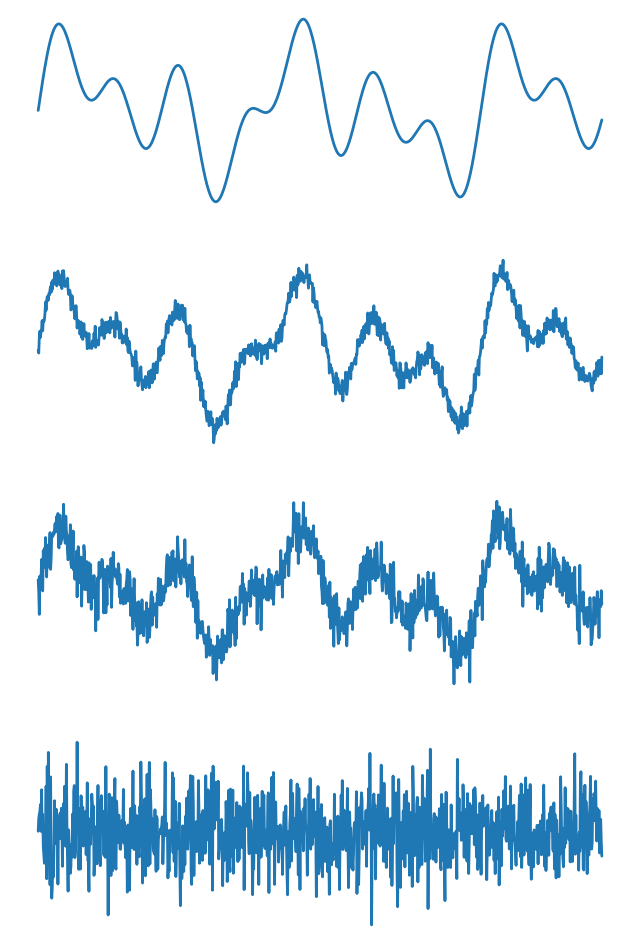

In [61]:
x = np.linspace(0, 40, 1000)
plt.figure(figsize=(8,12))

y = np.sin(0.8*x) + np.sin(0.4*x)+ np.sin(1.4*x)
plt.subplot(411)
plt.plot(x, y, linewidth=2)
plt.axis('off')

noise = np.random.normal(0, 0.2, size=1000)
y += noise
plt.subplot(412)
plt.plot(x, y, linewidth=2)
plt.axis('off')

noise = np.random.normal(0, 0.5, size=1000)
y += noise
plt.subplot(413)
plt.plot(x, y, linewidth=2)
plt.axis('off')

noise = np.random.normal(0, 1, size=1000)
y += noise
plt.subplot(414)
plt.plot(x, noise, linewidth=2)
plt.axis('off')

plt.savefig("../../plots/Forward-Process-Noise")
plt.show()

## Variance Schedule

In [62]:
from PIL import Image

img = Image.open('../../images/Tasse.jpg')
img = img.resize((512,512))
img = np.asarray(img)

In [63]:
T = 12
noisy_img = np.random.normal(0, 1, img.shape)
linear_schedule = np.linspace(0, 1, T)
sqrt_schedule = np.sqrt(linear_schedule)
squared_schedule = linear_schedule ** 2

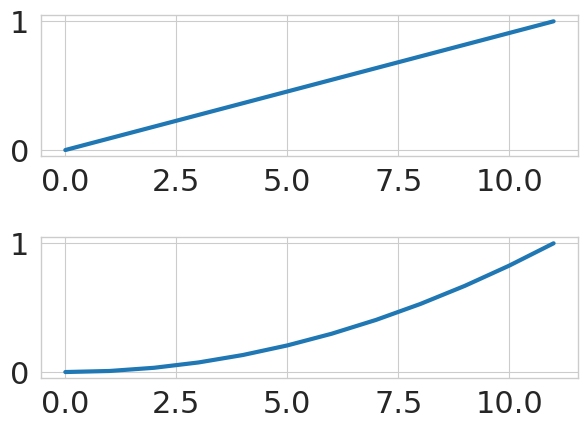

In [64]:
plt.subplot(211)
plt.plot(linear_schedule)
plt.subplot(212)
plt.plot(squared_schedule)
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

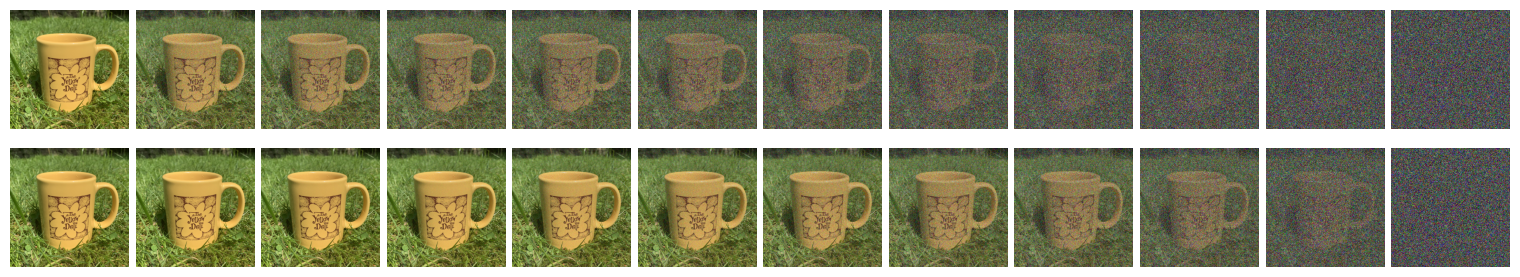

In [66]:
# NOTE: As a hacky way to communicate to the reader that the noise is increasing according to the variance schedule, we 
# simply show the noisy image above the original, with opacity increasing according to the different schedules. This 
# makes it IMO more visually appealing than actually corrupting the input image, and thus better suited to communicate 
# the concept in the thesis.

fig, axs = plt.subplots(2,T,figsize=(15,3))

i = 0
for col in axs[0]:
    col.imshow(img)
    col.imshow(noisy_img, alpha=sqrt_schedule[i])
    col.axis(False)
    i += 1

i = 0
for col in axs[1]:
    col.imshow(img)
    col.imshow(noisy_img, alpha=squared_schedule[i])
    col.axis(False)
    i += 1

plt.tight_layout(pad=0, w_pad=0.2, h_pad=0)
plt.savefig('../../plots/Variance Schedule', dpi=200)
plt.show()